# Product Pricing Informaion Gathering with Python

This Project will use an existing product list with part number to gather updated pricing by scraping the manufacturer's site and gathering the updated info into a new CSV file.

#### 1. Importing dependancies, adjusting settings and creating the backup function.

In [1]:
import pandas as pd 
import numpy as np
import requests
import time
import random
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from requests import get
import re
import pickle
pd.set_option('display.max_rows', 500)

In [2]:
#Setup backup functions to create binary backups of variables in case of a kernal crash or need to stop and restart the kernal:
def save(filename, *args):
    # Get global dictionary
    glob = globals()
    d = {}
    for v in args:
        # Copy over desired values
        d[v] = glob[v]
    with open(filename, 'wb') as f:
        # Put them in the file 
        pickle.dump(d, f)

def load(filename):
    # Get global dictionary
    glob = globals()
    with open(filename, 'rb') as f:
        for k, v in pickle.load(f).items():
            # Set each global variable to the value from the file
            glob[k] = v

def delay() -> None:
    time.sleep(random.uniform(5, 10))
    return None            

#### 2. Import CRM parts file with the part numbers needed.  I've manually removed information that's not needed so that we just have the part numbers for products we are interested in finding. With this particular CRM the Ergotron part numbers start with ERG allowing for filtering out other manufacturers within the program but in this example case I've done that already.

In [5]:
pn2 = []
pn2 = pd.read_csv('CRM.csv',  thousands=",")
pn2['Product Name'] = pn2['Product Name'].astype(str)
pn2 = pn2.loc[pn2['Product Name'].str.startswith('ERG', na=False)]
print(pn2.shape)
print(pn2.columns)


(339, 33)
Index(['Product Name', 'ID', 'Description', 'contact_id', 'Assigned to',
       'Assigned User Id', 'Date Created', 'Date Modified', 'Created By',
       'Modified By', 'Deleted', 'Product Code', 'Part Number', 'Category',
       'Product Type', 'Cost', 'Cost (Default Currency)', 'Currency', 'Price',
       'Price (Default Currency)', 'URL', 'Product Image',
       'Product Category ID', 'Modified By Name', 'modified_by_name_owner',
       'modified_by_name_mod', 'Created By.1', 'created_by_name_owner',
       'created_by_name_mod', 'assigned_user_name_owner',
       'assigned_user_name_mod', 'Contact', 'Product Category'],
      dtype='object')


In [6]:
pn2 = pn2.drop(['ID', 'contact_id', 'Assigned to',
       'Assigned User Id', 'Date Created', 'Date Modified', 'Created By',
       'Modified By', 'Deleted', 'Product Code', 'Category',
       'Product Type', 'Cost', 'Cost (Default Currency)', 'Currency',
       'Price (Default Currency)', 'URL', 'Product Image',
       'Product Category ID', 'Modified By Name', 'modified_by_name_owner',
       'modified_by_name_mod', 'Created By.1', 'created_by_name_owner',
       'created_by_name_mod', 'assigned_user_name_owner',
       'assigned_user_name_mod', 'Contact', 'Product Category'],axis=1)
print(pn2.head())

     Product Name                                        Description  \
0  ERG-33-397-085   WorkFit-T, Sit-Stand Desktop Workstation (black)   
1  ERG-61-367-030  CareFit Enclosure (snow white) Wall-mount comp...   
2  ERG-45-478-026      HX Wall Mount Monitor Arm (polished aluminum)   
3  ERG-24-313-026                               WorkFit-A, Single LD   
4  ERG-60-610-062  StyleView Sit-Stand Enclosure (bright white), ...   

  Part Number      Price  
0  33-397-085    $590.00  
1  61-367-030  $1,398.00  
2  45-478-026    $450.00  
3  24-313-026    $409.00  
4  60-610-062  $1,112.00  


#### 3. Making some modifications to the dataframe to help with data manipulation later.

In [7]:
pn2['Part Number'] = pn2['Product Name'].str.lstrip('ERG-')
pn2['PN_len'] = pn2['Part Number'].apply(len)
pn2.loc[pn2['PN_len'] == 10, 'Part Short'] = pn2['Part Number'].str[:6]
pn2.loc[pn2['PN_len'] == 11, 'Part Short'] = pn2['Part Number'].str[:9]
pn2.loc[pn2['Part Number'].str.contains('C50'), 'Part Short'] = pn2['Part Number'].str[:-2]
pn2['Part Short'] = pn2['Part Short'].fillna(pn2['Part Number'])
pn2.head()

,Product Name,Description,Part Number,Price,PN_len,Part Short
0,ERG-33-397-085,"WorkFit-T, Sit-Stand Desktop Workstation (black)",33-397-085,$590.00,10,33-397
1,ERG-61-367-030,CareFit Enclosure (snow white) Wall-mount comp...,61-367-030,"$1,398.00",10,61-367
2,ERG-45-478-026,HX Wall Mount Monitor Arm (polished aluminum),45-478-026,$450.00,10,45-478
3,ERG-24-313-026,"WorkFit-A, Single LD",24-313-026,$409.00,10,24-313
4,ERG-60-610-062,"StyleView Sit-Stand Enclosure (bright white), ...",60-610-062,"$1,112.00",10,60-610


#### 4. Collect the Unique Item IDs Used by The Traget Site
Due to the structure of the target wesite it was determined that the most effective way to extract the info needed was to first identify the product ID codes used in the website to pull up the pricing information from a json file. So this will be step 1 of a 2 step scraping process where we will get all the product IDs for the items in our starting dataframe and and add them to a list.

In [ ]:
item =[]
itme2 = []
def delay() -> None:
    time.sleep(random.uniform(5, 10))
    return None
item = pn2['Part Short']
item2 = pn2['Part Number']
headers = {'User-Agent': 'Mozilla/5.0'}
prod_id_df = []
part_num = []
p_id = []
actual_pn = []

for part, part2 in zip(item, item2):
    item_code = part
    full_prt = part2
    url = "https://partner.ergotron.com/en-us/products/product-details/{}#" .format(item_code)
    delay()
    r = requests.get(url, headers=headers)
    soup = BS(r.text, 'html.parser')
    try:
        target = soup.find("div", {"id": "dnn_ctr443_ContentPane"})
        target = str(target)
        tar = target.split("productId =",1)[1]
        tar = tar.split(",",1)[0]
        tar = re.sub("[^0-9]", "", tar)
    except:
        try:
            item_code = part2
            full_prt = part2
            url = "https://partner.ergotron.com/en-us/products/product-details/{}#" .format(item_code)
            delay()
            r = requests.get(url, headers=headers)
            soup = BS(r.text, 'html.parser')
            target = soup.find("div", {"id": "dnn_ctr443_ContentPane"})
            target = str(target)
            tar = target.split("productId =",1)[1]
            tar = tar.split(",",1)[0]
            tar = re.sub("[^0-9]", "", tar)
        except:    
            try:
                item_code = part2 
                full_prt = part2
                url = "https://partner.ergotron.com/en-us/products/product-details/{}" .format(item_code)
                delay()
                r = requests.get(url, headers=headers)
                soup = BS(r.text, 'html.parser')
                target = soup.find("div", {"id": "dnn_ctr443_ContentPane"})
                target = str(target)
                tar = target.split("productId =",1)[1]
                tar = tar.split(",",1)[0]
                tar = re.sub("[^0-9]", "", tar)
            except:    
                tar = "URL nonmatch"
    p_id.append(tar)
    part_num.append(item_code)
    actual_pn.append(full_prt)
prod_id_df= pd.DataFrame(
    {"part": part_num,
     "id": p_id,
     "Part Number": actual_pn
     })
    
prod_id_df.head()

In [ ]:
disc_items=['98-353-921','PM3616SM/MP','98-353-921','ABS4835SM-CG']
cust_item=['SV42-6201','45-270-216','45-253-026','45-271-026','45-383-026','97-464','45-549-026','45-622-251','45-270-026','97-909','24-391-026','24-190-085','45-304-026','97-942']
url_lst=['sv42-6201#',
        '45-272#/?color=white&cpu%20size%20option=Medium',
        '45-247#/?color=polished%20aluminum&cpu%20size%20option=Small',
        '45-273#/?color=polished%20aluminum&cpu%20size%20option=Medium',
        '45-353#/?capacity%20option=14–30%20lbs%20%2F%206.4–13.6%20kg&color=polished%20aluminum',
        'coiledextensioncordaccessorykit#/?power%20region=US%2FCA%2FMX',
        '45-509#/?color=polished%20aluminum',
        '45-621#/?color=white&worksurface%20option=Full%20worksurface',
        '45-272#/?color=polished%20aluminum&cpu%20size%20option=Medium',
        'svreplacementcoiledcordslacarts#/?power%20region=US%2FCA%2FMX',
        '24-390#/?capacity%20option=10–20%20lbs%20%2F%204.5–9.1%20kg&color=polished%20aluminum',
        '24-192#/?capacity%20option=25–50%20lbs%20%2F%2011.3–22.7%20kg&color=black',
        '45-296#/?capacity%20option=35–70%20lbs%20%2F%2015.9–31.8%20kg&color=polished%20aluminum',
        'svdcpowersystem#/?hardware%20configuration=for%20LCD%20%2B%20CPU']
cust_url= pd.DataFrame(
    {'part': cust_item,
    'url_tail': url_lst
    })
url_update = []
updt_prt = []
# for row in prod_id_df['part']:
#     if '98-353-921' in row:
#         prod_id_df['id'] = 'discontinued'
for row in range(len(cust_url)):
    url = "https://partner.ergotron.com/en-us/products/product-details/{}" .format((cust_url).loc[row, "url_tail"])
    # print(url)
    delay()
    r = requests.get(url, headers=headers)
    soup = BS(r.text, 'html.parser')
    try:
        target = soup.find("div", {"id": "dnn_ctr443_ContentPane"})
        target = str(target)
        tar = target.split("productId =",1)[1]
        tar = tar.split(",",1)[0]
        tar = re.sub("[^0-9]", "", tar)
    except:    
        tar = "URL nonmatch"
    url_update.append(tar)
cust_url['id']=url_update

cust_url.head()

**Backup and Reload Point**

 After successfully completeing the above opperations we should back up the variables to avoid repeated reruns of scraping opperations.

In [10]:
#backup dataframe variables
save("ergo_ps_backup", 'cust_url', 'pn2', 'prod_id_df', 'cust_item', 'disc_items')

In [3]:
#Load backup if needed
load("ergo_ps_backup")

In [5]:
#Correcting some of the missing IDs
prod_id_2 = []
prod_id_2 = prod_id_df.copy()
print(prod_id_2['id'].value_counts()['URL nonmatch'])
prod_id_2.set_index('part', inplace=True)
prod_id_2.update(cust_url.set_index('part'), overwrite=True)
prod_id_2.reset_index() 
print(prod_id_2['id'].value_counts()['URL nonmatch'])
prod_id_2.head()



24
19


,id,Part Number
part,,
33-397,143,33-397-085
61-367,1289,61-367-030
45-478,1055,45-478-026
24-313,48,24-313-026
60-610,273,60-610-062


In [6]:
#removing duplicates
print(len(prod_id_2))
prod_id_2 = prod_id_2.sort_values(['id']).drop_duplicates( keep='first')

print(len(prod_id_2))
prod_id_2.head()

339
319


,id,Part Number
part,,
24-189,10,24-189-055
31-016,100,31-016-182
31-017,101,31-017-182
31-018,102,31-018-216
31-018,102,31-018-182


In [13]:
prod_id_2['part']= prod_id_2.index
prod_id_2.reset_index(drop=True, inplace=True)
prod_id_2.head()

,id,Part Number,part
0,10,24-189-055,24-189
1,100,31-016-182,31-016
2,101,31-017-182,31-017
3,102,31-018-216,31-018
4,102,31-018-182,31-018


#### 5. Now we will take our product id list and add that to a new column in our dataframe and at the same time we will create a dataframe for those products for which we could not find a product ID. After looking over this list it mostly contains discontinued products.

In [7]:

pn3 =pn2.merge(right=prod_id_2[['Part Number','id']], left_on='Part Number', right_on='Part Number') 
print(pn3.shape)

# Check whether we have any missing ids:
redo = pn3[pn3.id.str.contains("URL nonmatch")]
pn3 = pn3[~pn3.id.str.contains("URL nonmatch")]
print(pn3.head())
print (redo.head())

(339, 7)
     Product Name                                        Description  \
0  ERG-33-397-085   WorkFit-T, Sit-Stand Desktop Workstation (black)   
1  ERG-61-367-030  CareFit Enclosure (snow white) Wall-mount comp...   
2  ERG-45-478-026      HX Wall Mount Monitor Arm (polished aluminum)   
3  ERG-45-478-026                         HX Wall mount monitor arm.   
4  ERG-24-313-026                               WorkFit-A, Single LD   

  Part Number      Price  PN_len Part Short    id  
0  33-397-085    $590.00      10     33-397   143  
1  61-367-030  $1,398.00      10     61-367  1289  
2  45-478-026    $450.00      10     45-478  1055  
3  45-478-026    $450.00      10     45-478  1055  
4  24-313-026    $409.00      10     24-313    48  
        Product Name                                        Description  \
12    ERG-98-353-921  WorkFit Electric Sit-Stand Desk, 46"W (black/g...   
13    ERG-98-353-921       WorkFit Electric Sit-Stand Desk, 46" Surface   
20  ERG-EPM3616SM/MP 

In [17]:
#backup dataframe variables
save("ergo_ps_backup", 'cust_url', 'pn2', 'prod_id_df', 'cust_item', 'disc_items','pn3','pn3')

In [18]:
#Load backup if needed
load("ergo_ps_backup")

#### 6. Determining whether items are discontinued or active and gathering SSP (suggested sale price) for each item.

With this site there is a field in the json file containing all the product info for each product that lists an "endDate" after which the product will be discontinued. We can read this date and determine if the parts are still active.

In [19]:

from datetime import datetime
import json
item7=pn3['id']
item8=pn3['Part Number']
headers = {'User-Agent': 'Mozilla/5.0'}
numbers = re.compile(r'\d+(?:\.\d+)?')
item_status = []
part_name = []
for part, num in zip(item7,item8):
    url = "https://partner.ergotron.com/DesktopModules/Ergotron/API/Client/GetProductDetails?culture=en-us&productId={}" .format(part)
    delay()
    r = requests.get(url, headers=headers).json()
    s = str(r)
    part_name.append(num)
    try:
        r_json = json.dumps(r['result'])
        r_json = json.loads(r_json)
        result_json = r_json[0]
        p1 = result_json["endDate"]
        try:
            p1_dt = datetime.strptime(p1,"%Y-%m-%dT%H:%M:%SZ")
            if p1_dt < datetime.today():
                item_status.append("EOL item")
            else:
                item_status.append('not EOL')
        except:
            item_status.append('no end date')
    except:
        item_status.append('invalid URL')


In [ ]:
pn4 = pn3[["Product Name","Part Number","id"]]
pn4.insert(3, "Status", item_status, True)
print (pn4.shape)
pn4.head()

In [21]:
redo2 = pn4[pn4['Status'].str.contains('EOL item') == True]
pn4 = pn4[pn4['Status'].str.contains('EOL item') == False]
print(redo2.shape)
print(pn4.shape)

(37, 4)
(283, 4)


Next we can actually gather the SSP pricing in the same way by adding the id to the URL in order to access a json file for each part.

In [22]:
import json
item4=pn4['id']
item3=pn4['Part Number']
headers = {'User-Agent': 'Mozilla/5.0'}
numbers = re.compile(r'\d+(?:\.\d+)?')
ssp = []
part_name = []
for part, num in zip(item4,item3):
    url = "https://partner.ergotron.com/DesktopModules/Ergotron/API/Client/GetProductDetails?culture=en-us&productId={}" .format(part)
    delay()
    r = requests.get(url, headers=headers).json()
    s = str(r)
    try:
        txt1 = s.split("'partNumber': '{}'".format(num),1)[1]
        txt2 = txt1.split("msrPrice",1)[1]
        txt3 = txt2.split(',',1)[0]
        val1 = numbers.findall(txt3)
        ssp.append(val1)
    except:
        try:
            txt1 = s.split("'partNumber': '{} '".format(num),1)[1]
            txt2 = txt1.split("msrPrice",1)[1]
            txt3 = txt2.split(',',1)[0]
            val1 = numbers.findall(txt3)
            ssp.append(val1)
        except:
            try:
                r_json = json.dumps(r['result'])
                r_json = json.loads(r_json)
                result_json = r_json[0]
                p1 = result_json['listPrice']
                val1 = numbers.findall(str(p1))
                ssp.append(val1)
            except:
                ssp.append("noprice")

    try:
        txt4 = txt1.split("'partName': ",1)[1]
        name1 = txt4.split(", 'msrPrice'",1)[0]
        part_name.append(name1)
    except:
        part_name.append("noname")
print(ssp)
print(part_name)

[['614.0'], ['1426.0'], ['455.0'], ['455.0'], ['26.0'], ['119.0'], ['120.0'], ['421.0'], ['156.0'], ['2784.0'], ['1091.0'], ['1091.0'], ['1091.0'], ['73.0'], ['88.0'], ['41.0'], ['49.0'], ['40.0'], ['523.0'], ['77.0'], ['221.0'], ['1250.0'], ['1122.0'], ['2039.0'], ['57.0'], ['714.0'], ['6000.0'], ['111.0'], ['111.0'], ['582.0'], ['582.0'], ['121.0'], ['1070.0'], ['780.0'], ['182.0'], ['1057.0'], ['442.0'], ['274.0'], ['167.0'], [], ['92.0'], ['867.0'], ['41.0'], ['455.0'], ['57.0'], ['1323.0'], ['181.0'], ['1426.0'], ['1182.0'], ['180.0'], ['622.0'], ['126.0'], ['126.0'], ['208.0'], ['429.0'], ['135.0'], ['257.0'], ['136.0'], ['106.0'], ['867.0'], ['851.0'], ['1059.0'], ['1417.0'], ['75.0'], ['56.0'], ['1959.0'], ['739.0'], ['1921.0'], ['40.0'], ['40.0'], ['285.0'], ['62.0'], ['62.0'], ['81.0'], ['1053.0'], ['317.0'], ['79.0'], ['6058.0'], ['150.0'], ['112.0'], ['97.0'], ['282.0'], ['123.0'], ['276.0'], ['238.0'], ['158.0'], ['165.0'], ['214.0'], ['446.0'], ['403.0'], ['1259.0'], ['47

#### 7. Next let's create new columns in our main dataframe for these new values we've gathered.

In [23]:
pn5 = pn4[["Product Name","Part Number","id","Status"]]
pn5.insert(4, "SSP", ssp, True)
pn5.insert(5, "Description", part_name, True)
pn5.head()

,Product Name,Part Number,id,Status,SSP,Description
0,ERG-33-397-085,33-397-085,143,no end date,[614.0],"'WorkFit-T, Standing Desk Workstation (black w..."
1,ERG-61-367-030,61-367-030,1289,no end date,[1426.0],'CareFit™ Enclosure (white)'
2,ERG-45-478-026,45-478-026,1055,no end date,[455.0],'HX Wall Monitor Arm (polished aluminum)'
3,ERG-45-478-026,45-478-026,1055,no end date,[455.0],'HX Wall Monitor Arm (polished aluminum)'
7,ERG-98-017,98-017,536,no end date,[26.0],'LX Arm Grommet Mount'


In [24]:
# #check if we have any unexpected values in ssp
# print(pn5[pn5['SSP']=='noprice'])
# print(pn5[pn5['SSP']=='[]'])
# pn5[pn5['SSP'].str.contains('') == True]


Empty DataFrame
Columns: [Product Name, Part Number, id, Status, SSP, Description]
Index: []
Empty DataFrame
Columns: [Product Name, Part Number, id, Status, SSP, Description]
Index: []


,Product Name,Part Number,id,Status,SSP,Description


#### 8. Clean the data so that text and number formating is correct.

In [ ]:
pn5['SSP'] = pn5['SSP'].astype(str)
pn5['SSP']=pn5['SSP'].str.replace('[','', regex=True).str.replace(']','', regex=True)
pn5['SSP']=pn5['SSP'].str.replace("'",'', regex=True).str.replace("'",'', regex=True)
pn5['Description']=pn5['Description'].str.replace(",",'', regex=True)
pn5['SSP']=pn5['SSP'].replace('', np.nan)
pn5['SSP'].fillna(0, inplace=True)
pn5=pn5.astype({"SSP":"float"})
pn5.head()

In [26]:
#drop rows with ssp == 0
print (pn5.shape)
pn5 = pn5[pn5['SSP'] != 0]
print (pn5.shape)

(283, 6)
(276, 6)


In [27]:
#backup dataframe variables
save("ergo_ps_backup", 'cust_url', 'pn2', 'prod_id_df', 'cust_item', 'disc_items','pn3','ssp','part_name','pn3','pn4','pn5','redo','redo2')

In [4]:
#Load backup if needed
load("ergo_ps_backup")

#### Check the amount of price change to look for unexpected changes

In [33]:
# Checking for large changes against exisitng prices

pn2_dd = pn2.drop_duplicates(subset='Product Name', keep ='first')
pn5_dd = pn5.drop_duplicates(subset='Product Name', keep = 'first')
pn5_dd = pn5_dd.merge(pn2_dd[['Product Name','Price']], how = 'left', left_on='Product Name',right_on='Product Name')
pn5_dd = pn5_dd.drop_duplicates(subset='Description', keep = 'first')
pn5_dd.head()

,Product Name,Part Number,id,Status,SSP,Description,Price
0,ERG-33-397-085,33-397-085,143,no end date,614.0,'WorkFit-T Standing Desk Workstation (black wi...,$590.00
1,ERG-61-367-030,61-367-030,1289,no end date,1426.0,'CareFit™ Enclosure (white)',"$1,398.00"
2,ERG-45-478-026,45-478-026,1055,no end date,455.0,'HX Wall Monitor Arm (polished aluminum)',$450.00
3,ERG-98-017,98-017,536,no end date,26.0,'LX Arm Grommet Mount',$25.00
4,ERG-97-617,97-617,385,no end date,119.0,'WorkFit Conversion Kit: Dual to LCD & Laptop',$114.00


In [34]:
pn5_dd['Price'] = pn5_dd['Price'].astype(str)
pn5_dd['Price']=pn5_dd['Price'].str.replace('$','', regex=True).str.replace(',','', regex=True)

pn5_dd.head()

,Product Name,Part Number,id,Status,SSP,Description,Price
0,ERG-33-397-085,33-397-085,143,no end date,614.0,'WorkFit-T Standing Desk Workstation (black wi...,590.00
1,ERG-61-367-030,61-367-030,1289,no end date,1426.0,'CareFit™ Enclosure (white)',1398.00
2,ERG-45-478-026,45-478-026,1055,no end date,455.0,'HX Wall Monitor Arm (polished aluminum)',450.00
3,ERG-98-017,98-017,536,no end date,26.0,'LX Arm Grommet Mount',25.00
4,ERG-97-617,97-617,385,no end date,119.0,'WorkFit Conversion Kit: Dual to LCD & Laptop',114.00


In [35]:
#adding a column for amount of change in price
pn5_dd['Percent Change']=1-(pn5_dd['Price'].astype(float)/pn5_dd['SSP'].astype(float))
pn5_dd.head()

,Product Name,Part Number,id,Status,SSP,Description,Price,Percent Change
0,ERG-33-397-085,33-397-085,143,no end date,614.0,'WorkFit-T Standing Desk Workstation (black wi...,590.00,0.039088
1,ERG-61-367-030,61-367-030,1289,no end date,1426.0,'CareFit™ Enclosure (white)',1398.00,0.019635
2,ERG-45-478-026,45-478-026,1055,no end date,455.0,'HX Wall Monitor Arm (polished aluminum)',450.00,0.010989
3,ERG-98-017,98-017,536,no end date,26.0,'LX Arm Grommet Mount',25.00,0.038462
4,ERG-97-617,97-617,385,no end date,119.0,'WorkFit Conversion Kit: Dual to LCD & Laptop',114.00,0.042017


In [36]:
#Create a new df for unusual price changes to double check before changes made in system
flag_price = pn5_dd.loc[(pn5_dd['Percent Change']>.4)|(pn5_dd['Percent Change']<0)]
flag_price

,Product Name,Part Number,id,Status,SSP,Description,Price,Percent Change


#### Add CRM system unique IDs
In order to properly import the updated information into the CRM system we needed to match the parts with the unique ID numbers generated by the CRM. In the future this could be done on the initial import.

In [38]:

crm_1 = pd.read_csv('CRM.csv',  thousands=",")
crm_1.rename(columns={"ID": "crm_ID"}, inplace=True)
crm_1.drop(columns=['Description', 'contact_id', 'Assigned to',
       'Assigned User Id', 'Date Created', 'Date Modified', 'Created By',
       'Modified By', 'Deleted', 'Product Code', 'Part Number', 'Category',
       'Product Type', 'Cost', 'Cost (Default Currency)', 'Currency', 'Price',
       'Price (Default Currency)', 'URL', 'Product Image',
       'Product Category ID', 'Modified By Name', 'modified_by_name_owner',
       'modified_by_name_mod', 'Created By.1', 'created_by_name_owner',
       'created_by_name_mod', 'assigned_user_name_owner',
       'assigned_user_name_mod', 'Contact', 'Product Category'], inplace=True)
crm_1.head()

,Product Name,crm_ID
0,ERG-33-397-085,1001cee2-12d6-dabd-0765-54aec2451f45
1,ERG-61-367-030,11bd2dfd-f754-a5d2-c45d-5e5eaf825641
2,ERG-45-478-026,11ca3cd7-405c-38ca-42c4-58d43d63d597
3,ERG-24-313-026,120c6e18-bd67-4b6b-ff5a-53ee6dd096f9
4,ERG-60-610-062,13196af5-5189-69ef-d247-528634d65620


In [39]:
pn5_dd = pn5_dd.merge(crm_1[['Product Name','crm_ID']], how = 'left', left_on='Product Name',right_on='Product Name')
pn5_dd.head()

,Product Name,Part Number,id,Status,SSP,Description,Price,Percent Change,crm_ID
0,ERG-33-397-085,33-397-085,143,no end date,614.0,'WorkFit-T Standing Desk Workstation (black wi...,590.00,0.039088,1001cee2-12d6-dabd-0765-54aec2451f45
1,ERG-61-367-030,61-367-030,1289,no end date,1426.0,'CareFit™ Enclosure (white)',1398.00,0.019635,11bd2dfd-f754-a5d2-c45d-5e5eaf825641
2,ERG-45-478-026,45-478-026,1055,no end date,455.0,'HX Wall Monitor Arm (polished aluminum)',450.00,0.010989,11ca3cd7-405c-38ca-42c4-58d43d63d597
3,ERG-45-478-026,45-478-026,1055,no end date,455.0,'HX Wall Monitor Arm (polished aluminum)',450.00,0.010989,6f07ea7f-61f9-2cbd-f832-5d3f48380849
4,ERG-98-017,98-017,536,no end date,26.0,'LX Arm Grommet Mount',25.00,0.038462,1381e37e-fc5d-9bff-0a59-5d5bff0bc399


Next let's visualize the change per item to try to identify any spikes and to get an overall idea of common change amounts.

In [10]:
pn5_dd.shape

(262, 9)

In [21]:
!pip install seaborn

     -------------------------------------- 294.9/294.9 kB 2.3 MB/s eta 0:00:00


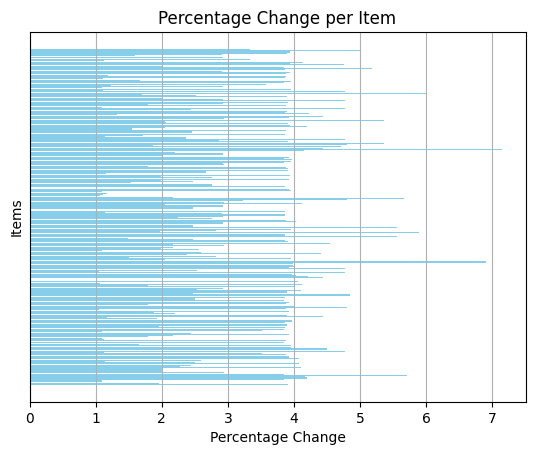

In [23]:
import matplotlib.pyplot as plt
import numpy as np

num_items = pn5_dd.shape[0]
item_names = [f'Item {i}' for i in range(1, num_items + 1)]
percentage_changes = pn5_dd['Percent Change']*100

# Create a horizontal bar plot
plt.barh(item_names, percentage_changes, color='skyblue')

# Set labels and title
plt.xlabel('Percentage Change')
plt.ylabel('Items')
plt.title('Percentage Change per Item')

# Add grid lines for better readability
plt.grid(axis='x')

# remove label for y axis
plt.yticks([])

# Show the plot
plt.show()

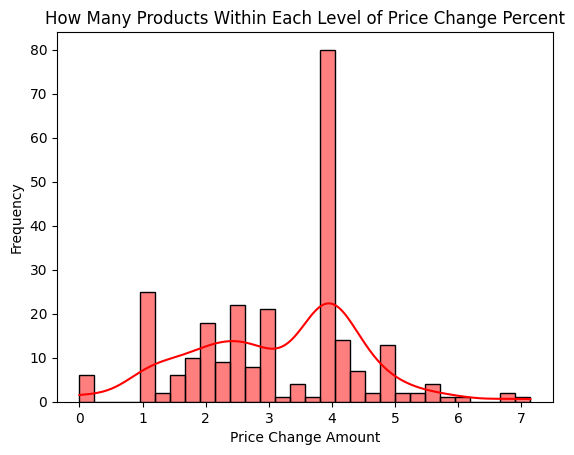

In [24]:
import seaborn as sns
import numpy as np

# Create a Seaborn histogram with KDE
sns.histplot(percentage_changes, kde=True, color='red', bins=30)

# Set labels and title
plt.xlabel('Price Change Amount')
plt.ylabel('Frequency')
plt.title('How Many Products Within Each Level of Price Change Percent')

# Show the plot
plt.show()

#### CSV File Output

In [40]:
redo.to_csv(r'./inv_items.csv', index = False)
redo2.to_csv(r'./disc_items.csv', index = False)

In [41]:
pn5_dd.to_csv(r'./erg_web_price.csv', index = False)


## Backup and Reload Point

In [42]:
save("ergo_ps_backup", 'cust_url', 'pn2', 'prod_id_df', 'cust_item', 'disc_items','pn3','ssp','part_name','pn3','pn4','pn5','redo','redo2','pn5_dd')

In [3]:
#Load backup if needed
load("ergo_ps_backup")